<a href="https://colab.research.google.com/github/masamune-prog/E-card/blob/main/Simulation%20Framwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

E Card Game

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def outcome_game(player1_card, player2_card):
    # Determine winner of a single draw:
    # return 1 if player1 (first player passed) wins the draw,
    # return -1 if player2 wins the draw,
    # return 0 if tie.
    if player1_card == player2_card:
        return 0
    # Winning rules: Emperor (K) beats Citizen (C); Citizen (C) beats Slave (S); Slave (S) beats Emperor (K)
    if player1_card == "K" and player2_card == "C":
        return 1
    if player1_card == "C" and player2_card == "S":
        return 1
    if player1_card == "S" and player2_card == "K":
        return 1
    # Otherwise player2 wins the draw
    return -1



In [ ]:
def random_policy(hand, opponent_hand=None):
    #from hand, play a random card
    return hand.pop(random.randint(0, len(hand) - 1))

In [ ]:
def yolo_policy(hand, opponent_hand=None):
    #from hand play "K" if possible, else "S" You only live once!
    if "K" in hand:
        hand.remove("K")
        return "K"
    else:
        return "S"

In [ ]:
def minimax_policy(hand, opponent_hand=None):
    """
    Minimax policy: Assumes opponent plays optimally and chooses the move
    that maximizes the worst-case outcome.
    """
    if opponent_hand is None or len(opponent_hand) == 0:
        # Fallback to random if no opponent info
        return hand.pop(random.randint(0, len(hand) - 1))

    # Get unique cards we can play
    available_cards = list(set(hand))

    # Evaluate each possible move
    best_card = None
    best_value = float('-inf')

    for my_card in available_cards:
        # For this card, find worst-case outcome against opponent's best response
        worst_value = float('inf')

        opponent_cards = list(set(opponent_hand))
        for opp_card in opponent_cards:
            # Calculate outcome if opponent plays this card
            result = outcome_game(my_card, opp_card)
            worst_value = min(worst_value, result)

        # Choose the move with the best worst-case outcome
        if worst_value > best_value:
            best_value = worst_value
            best_card = my_card

    # Remove and return the chosen card
    hand.remove(best_card)
    return best_card

In [ ]:
def expectimax_policy(hand, opponent_hand=None):
    """
    Expectimax policy: Chooses the card that maximizes expected value
    based on the probability distribution of opponent's remaining cards.
    """
    if opponent_hand is None or len(opponent_hand) == 0:
        # Fallback to random if no opponent info
        return hand.pop(random.randint(0, len(hand) - 1))

    # Get unique cards we can play
    available_cards = list(set(hand))

    # Count opponent's cards to estimate probabilities
    opp_card_counts = {}
    for card in opponent_hand:
        opp_card_counts[card] = opp_card_counts.get(card, 0) + 1

    total_opp_cards = len(opponent_hand)

    # Calculate expected value for each of our possible moves
    best_card = None
    best_expected_value = float('-inf')

    for my_card in available_cards:
        expected_value = 0.0

        # Calculate expected outcome against opponent's distribution
        for opp_card, count in opp_card_counts.items():
            probability = count / total_opp_cards
            outcome = outcome_game(my_card, opp_card)
            expected_value += probability * outcome

        # Choose the card with highest expected value
        if expected_value > best_expected_value:
            best_expected_value = expected_value
            best_card = my_card

    # Remove and return the chosen card
    hand.remove(best_card)
    return best_card

In [ ]:
slave_deck = ["C","C","C","C","S"]
king_deck = ["C","C","C","C","K"]


class Player:
    def __init__(self, name, hand,policy):
        self.name = name
        self.original_hand = hand.copy()  # Create a copy to avoid modifying the input
        self.hand = self.original_hand.copy()
        self.score = 0
        self.policy = policy
    def play_card(self, opponent_hand=None):
        #play a card based on the policy
        card_drawn = self.policy(self.hand, opponent_hand)
        #print(self.hand)
        return card_drawn
    def reset_hand(self):
        self.hand = self.original_hand.copy()
    def reset_score(self):
        self.score = 0

In [ ]:
#single game class
class Round():
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2

    def play_round(self):
        # self.player1.reset_hand()
        # self.player2.reset_hand()
        # self.player1.reset_score()
        # self.player2.reset_score()
        while self.player1.hand and self.player2.hand:
            # policies receive (player, opponent) and must remove/return a card from player's deck
            card1 = self.player1.play_card(self.player2.hand.copy())
            card2 = self.player2.play_card(self.player1.hand.copy())
            #print(card1,card2)
            # determine draw outcome: 1 -> player1 wins draw, -1 -> player2 wins draw, 0 -> tie
            result = outcome_game(card1, card2)
            if result != 0:
                #print("Game done," + (" player 1 wins" if result > 0 else " player 2 wins"))
                # score is applied at match level (Game.play_one_match) so this single draw returns the result
                #reset hands
                self.player1.reset_hand()
                self.player2.reset_hand()
                #print(card1,card2,result)
                return card1, card2, result
        # if decks empty without winner, return tie, imposible situation
        return None, None, 0

In [ ]:
class PolicyComparison:
    """
    Class to compare a King policy against a Slave policy.
    """
    def __init__(self, king_policy, slave_policy, king_name="King", slave_name="Slave"):
        """
        Initialize with two policies to compare.

        Args:
            king_policy: Policy function for King player
            slave_policy: Policy function for Slave player
            king_name: Name/label for the King's policy
            slave_name: Name/label for the Slave's policy
        """
        self.king_policy = king_policy
        self.slave_policy = slave_policy
        self.king_name = king_name
        self.slave_name = slave_name
        self.results = None
    def reset(self):
        self.results = None


    def run_simulation(self,n_rounds_list = [100, 1000, 10000, 100000], replicates=100):
        """
        Run simulation comparing the two policies.

        Args:
            n_rounds: Number of rounds per replicate
            n_replicates: Number of replicates to run
        """

        king = Player("king", king_deck.copy(), self.king_policy)
        slave = Player("slave", slave_deck.copy(), self.slave_policy)
        round = Round(king, slave)
        #replicates = 100
        #n_rounds_list = [100, 1000, 10000, 100000]
        king_scores = []
        slave_scores = []
        for n_rounds in n_rounds_list:
            replicates_scores_king = []
            replicates_scores_slave = []
            for i in range(replicates):
                king.reset_score()
                slave.reset_score()
                for j in range(n_rounds):
                    winner = round.play_round()
                    if winner[2] == 1:
                        king.score += 1
                    elif winner[2] == -1:
                        slave.score += 4
                replicates_scores_king.append(king.score)
                replicates_scores_slave.append(slave.score)
            # Calculate average score per round
            king_scores.append((sum(replicates_scores_king) / replicates) / n_rounds)
            slave_scores.append((sum(replicates_scores_slave) / replicates) / n_rounds)

        plt.plot(n_rounds_list, king_scores, label="King")
        plt.plot(n_rounds_list, slave_scores, label="Slave")
        plt.xlabel("Number of Rounds")
        plt.ylabel("Average Score per Round")
        plt.title("Convergence of Average Score (King vs Slave)")
        plt.legend()
        plt.xscale('log') # Log scale helps visualize the orders of magnitude better
        plt.show()



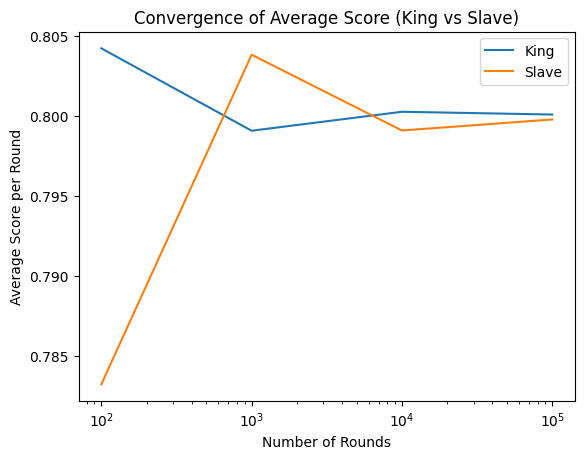

In [ ]:
comparison = PolicyComparison(
    king_policy=expectimax_policy,
    slave_policy=random_policy,
    king_name="Expectimax",
    slave_name="Random"
)

# Run simulation
comparison.run_simulation()


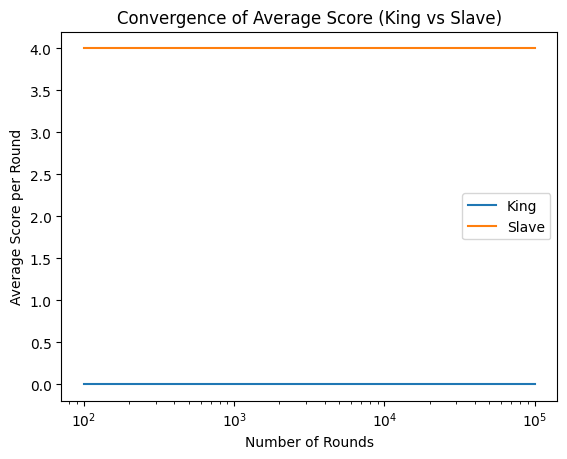

In [ ]:
comparison = PolicyComparison(
    king_policy=expectimax_policy,
    slave_policy=yolo_policy,
    king_name="Expectimax",
    slave_name="Random"
)

# Run simulation
comparison.run_simulation()


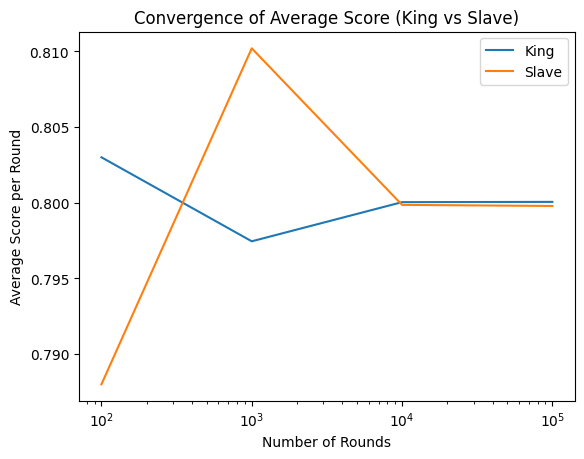

In [ ]:
comparison = PolicyComparison(
    king_policy=random_policy,
    slave_policy=random_policy,
    king_name="Random",
    slave_name="Random"
)

# Run simulation
comparison.run_simulation()


In [ ]:
# Simulation to verify win probabilities (King ~0.8, Slave ~0.2)

# Setup simulation parameters
n_rounds_list = [10, 100, 1000, 10000, 100000]
n_replicates = 100

# Store results for each replicate
king_win_rates_all = []
slave_win_rates_all = []

# Initialize players with random policy
king_sim = Player("king", king_deck, random_policy)
slave_sim = Player("slave", slave_deck, random_policy)
round_sim = Round(king_sim, slave_sim)

for n in n_rounds_list:
    king_rates_replicates = []
    slave_rates_replicates = []

    for rep in range(n_replicates):
        king_wins = 0
        slave_wins = 0
        for _ in range(n):
            # play_round returns (card1, card2, result)
            # result 1 = King wins, -1 = Slave wins
            _, _, result = round_sim.play_round()

            if result == 1:
                king_wins += 1
            elif result == -1:
                slave_wins += 1

        king_rates_replicates.append(king_wins / n)
        slave_rates_replicates.append(slave_wins / n)

    king_win_rates_all.append(king_rates_replicates)
    slave_win_rates_all.append(slave_rates_replicates)

# Calculate means and standard deviations
king_mean = [np.mean(rates) for rates in king_win_rates_all]
king_std = [np.std(rates) for rates in king_win_rates_all]
slave_mean = [np.mean(rates) for rates in slave_win_rates_all]
slave_std = [np.std(rates) for rates in slave_win_rates_all]

# Plot: Win rates with error bars
plt.errorbar(n_rounds_list, king_mean, yerr=king_std, label="King Win Rate",
             marker='o', capsize=5, capthick=2)
plt.errorbar(n_rounds_list, slave_mean, yerr=slave_std, label="Slave Win Rate",
             marker='o', capsize=5, capthick=2)

# Theoretical lines
plt.axhline(y=0.8, color='blue', linestyle='--', alpha=0.5, label="Theoretical King (0.8)")
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label="Theoretical Slave (0.2)")

plt.xscale('log')
plt.xlabel("Number of Rounds (Log Scale)")
plt.ylabel("Win Rate")
plt.title("Convergence of Win Rates: King vs Slave (Random Policy)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 60)
for i, n in enumerate(n_rounds_list):
    print(f"\nn = {n:,} rounds:")
    print(f"  King:  Mean = {king_mean[i]:.4f}, SD = {king_std[i]:.4f}")
    print(f"  Slave: Mean = {slave_mean[i]:.4f}, SD = {slave_std[i]:.4f}")

In [ ]:
#define thr Q learning agent
#agent have 2 options, play C or play special card (K or S)
class QLearningPlayer(Player):
    def __init__(self,name,hand, epilson=0.1, alpha=0.5, gamma=0.9):
        super().__init__(name,hand,policy=None)
        self.epsilon = epilson  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.q_table = {}       # Q-value table
        #memory for last state and action
        self.last_state = None
        self.last_action = None
    #we can represent state as how many citizens and if we have played the face card
    def get_state(self):
        num_C = self.hand.count("C")
        has_special = 1 if "K" in self.hand or "S" in self.hand else 0
        return (num_C, has_special)
    def play_card(self, opponent_hand=None):
        state = self.get_state()
        #remember state for learning later
        self.last_state = state
        avail_actions = list(set(self.hand))
        #initialize q values for state if not present
        if state not in self.q_table:
            self.q_table[state] = {action: 0.0 for action in avail_actions}
        #epsilon-greedy action selection
        if len(avail_actions) == 1:
            action = avail_actions[0]
        elif random.random() < self.epsilon:
            action = random.choice(avail_actions)
        else:
            #choose action with highest q value among available actions
            q_values = self.q_table[state]
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            action = random.choice(best_actions)



In [ ]:
import numpy as np
import random

# --- Constants ---
CARD_KING = "K"
CARD_SLAVE = "S"
CARD_CITIZEN = "C"

# Outcomes
WIN = 1
LOSS = -1
TIE = 0

# --- Base Player Class (Provided by User) ---
class Player:
    def __init__(self, name, hand, policy=None):
        self.name = name
        self.original_hand = hand.copy()  # Create a copy to avoid modifying the input
        self.hand = self.original_hand.copy()
        self.score = 0
        self.policy = policy # Function or None

    def play_card(self, opponent_hand=None):
        # If a specific policy function exists, use it
        if self.policy:
            card_drawn = self.policy(self.hand, opponent_hand)
        else:
            # Default fallback: Random choice if no policy
            card_drawn = random.choice(self.hand)
            self.hand.remove(card_drawn)

        return card_drawn

    def reset_hand(self):
        self.hand = self.original_hand.copy()

    def reset_score(self):
        self.score = 0


# --- Q-Learning Integration ---

class QLearningPlayer(Player):
    def __init__(self, name, role, epsilon=0.1, alpha=0.1, gamma=0.95):
        # Construct the correct deck based on role
        hand = [CARD_CITIZEN] * 4
        if role == "King":
            hand.append(CARD_KING)
        else:
            hand.append(CARD_SLAVE)

        # Initialize the parent Player class
        # We pass None for policy because we override play_card directly
        super().__init__(name, hand, policy=None)

        self.role = role
        self.q_table = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

        # Memory to store the state/action pair for the *current* turn
        # so we can update it when the reward arrives.
        self.last_state = None
        self.last_action = None

    def get_state(self):
        """Converts current hand into a hashable state tuple."""
        c_count = self.hand.count(CARD_CITIZEN)

        has_special = 0
        if self.role == "King" and CARD_KING in self.hand:
            has_special = 1
        elif self.role == "Slave" and CARD_SLAVE in self.hand:
            has_special = 1

        return (c_count, has_special)

    def play_card(self, opponent_hand=None):
        """
        Acts as the Policy.
        1. Observes State
        2. Chooses Action (Epsilon-Greedy)
        3. Removes card from hand (Side Effect)
        4. Returns card
        """
        state = self.get_state()
        self.last_state = state # Remember state for learning later

        # 1. Identify Valid Actions
        valid_actions = []
        if CARD_CITIZEN in self.hand:
            valid_actions.append("PLAY_CITIZEN")
        if (self.role == "King" and CARD_KING in self.hand) or \
           (self.role == "Slave" and CARD_SLAVE in self.hand):
            valid_actions.append("PLAY_SPECIAL")

        # 2. Choose Action (Epsilon-Greedy)
        action_key = ""

        # Initialize Q-table for this state if missing
        if state not in self.q_table:
            self.q_table[state] = {a: 0.0 for a in ["PLAY_CITIZEN", "PLAY_SPECIAL"]}

        if len(valid_actions) == 1:
            action_key = valid_actions[0]
        elif random.uniform(0, 1) < self.epsilon:
            action_key = random.choice(valid_actions)
        else:
            # Exploit: Choose max Q among VALID actions only
            q_vals = {a: self.q_table[state].get(a, 0.0) for a in valid_actions}
            max_q = max(q_vals.values())
            # Break ties randomly
            best_actions = [a for a, q in q_vals.items() if q == max_q]
            action_key = random.choice(best_actions)

        self.last_action = action_key # Remember action for learning later

        # 3. Execute (Remove card from hand)
        card_to_play = ""
        if action_key == "PLAY_CITIZEN":
            card_to_play = CARD_CITIZEN
            self.hand.remove(CARD_CITIZEN)
        else:
            if self.role == "King":
                card_to_play = CARD_KING
                self.hand.remove(CARD_KING)
            else:
                card_to_play = CARD_SLAVE
                self.hand.remove(CARD_SLAVE)

        return card_to_play

    def learn_result(self, reward, game_done):
        """
        Updates the Q-table based on the reward received for the
        last action taken.
        """
        if self.last_state is None or self.last_action is None:
            return

        # Current state is actually the *next* state (after card removal)
        next_state = self.get_state()

        # Calculate max Q for the next state
        max_future_q = 0.0
        if not game_done:
            if next_state not in self.q_table:
                self.q_table[next_state] = {a: 0.0 for a in ["PLAY_CITIZEN", "PLAY_SPECIAL"]}
            # Simple max over all potential actions in next state
            max_future_q = max(self.q_table[next_state].values())

        # Q-Learning Formula
        current_q = self.q_table[self.last_state][self.last_action]
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

        self.q_table[self.last_state][self.last_action] = new_q


# --- Game Logic & Simulation ---

def determine_winner(card_k, card_s):
    if card_k == card_s: return 0
    if card_k == CARD_KING:
        return 1 if card_s == CARD_CITIZEN else -1
    if card_k == CARD_CITIZEN:
        return 0 if card_s == CARD_CITIZEN else 1
    return 0

def run_benchmark(king_agent, slave_agent, episodes=5000):
    """
    Runs a match between two agents in 'Eval Mode' (no learning).
    Useful for comparing a Trained Agent vs a Random Agent.
    """
    print(f"\n--- Benchmarking: {king_agent.name} (King) vs {slave_agent.name} (Slave) ---")

    # Store original epsilons to restore later (if they exist)
    old_eps_k = getattr(king_agent, 'epsilon', None)
    old_eps_s = getattr(slave_agent, 'epsilon', None)

    # Force exploitation (Greedy)
    if hasattr(king_agent, 'epsilon'): king_agent.epsilon = 0
    if hasattr(slave_agent, 'epsilon'): slave_agent.epsilon = 0

    k_wins = 0
    s_wins = 0
    ties = 0

    for _ in range(episodes):
        king_agent.reset_hand()
        slave_agent.reset_hand()

        round_over = False
        while not round_over:
            c_k = king_agent.play_card()
            c_s = slave_agent.play_card()

            res = determine_winner(c_k, c_s)

            if res == 1:
                k_wins += 1
                round_over = True
            elif res == -1:
                s_wins += 1
                round_over = True
            else:
                if not king_agent.hand:
                    ties += 1
                    round_over = True

    # Restore training parameters
    if old_eps_k is not None: king_agent.epsilon = old_eps_k
    if old_eps_s is not None: slave_agent.epsilon = old_eps_s

    print(f"King Wins: {k_wins} ({k_wins/episodes*100:.1f}%)")
    print(f"Slave Wins: {s_wins} ({s_wins/episodes*100:.1f}%)")
    print(f"Ties:      {ties} ({ties/episodes*100:.1f}%)")

def run_integrated_simulation():
    # 1. Instantiate QLearningPlayers
    p_king = QLearningPlayer(name="Q-King", role="King")
    p_slave_smart = QLearningPlayer(name="Q-Slave", role="Slave")

    # 2. Instantiate a Dumb Dummy for Training (Random Policy)
    deck_slave_rand = [CARD_CITIZEN]*4 + [CARD_SLAVE]
    p_slave_random = Player(name="Random-Slave", hand=deck_slave_rand)

    episodes = 30000 # Increased episodes slightly for mixed training

    print(f"--- Training Phase ({episodes} episodes) ---")
    print("Training Strategy: 50% vs Smart Slave, 50% vs Random Slave")

    for ep in range(episodes):
        p_king.reset_hand()

        # --- OPPONENT SELECTION ---
        # 50% chance to play against the Dummy.
        # This teaches the King: "Aggression pays off if the opponent makes mistakes"
        # 50% chance to play against the Smart Q-Slave.
        # This teaches the King: "Be careful not to be too predictable"
        if random.random() < 0.5:
            current_opponent = p_slave_random
            is_learning_opponent = False
        else:
            current_opponent = p_slave_smart
            is_learning_opponent = True

        current_opponent.reset_hand()

        # Decay epsilon
        if ep % 2000 == 0 and p_king.epsilon > 0.05:
            p_king.epsilon *= 0.9
            p_slave_smart.epsilon *= 0.9

        round_over = False

        while not round_over:
            # --- ACTION STEP ---
            c_king = p_king.play_card()
            c_slave = current_opponent.play_card()

            # --- EVALUATION STEP ---
            result = determine_winner(c_king, c_slave)

            # --- REWARD CALCULATION ---
            r_king = 0
            r_slave = 0
            game_done = False

            if result == 1: # King Wins
                r_king = 1
                r_slave = -1
                game_done = True
            elif result == -1: # Slave Wins
                r_king = -1
                r_slave = 1
                game_done = True
            else: # Tie
                if not p_king.hand:
                    game_done = True

            # --- LEARNING STEP ---
            # King ALWAYS learns
            p_king.learn_result(r_king, game_done)

            # Slave ONLY learns if it is the Smart Slave
            if is_learning_opponent:
                p_slave_smart.learn_result(r_slave, game_done)

            if game_done:
                round_over = True

    print("Training Complete.")

    # --- BENCHMARKING PHASE ---

    deck_king_rand = [CARD_CITIZEN]*4 + [CARD_KING]
    rand_king = Player(name="Random-King", hand=deck_king_rand)

    # 1. Test: Trained King vs Random Slave
    # Did the training against the Random pool help it exploit randomness?
    run_benchmark(p_king, p_slave_random)

    # 2. Test: Random King vs Trained Slave
    # Is the Slave still smart enough to beat a random player?
    run_benchmark(rand_king, p_slave_smart)

    # 3. Test: Trained vs Trained (The Final Exam)
    # Does the King now perform better against the Smart Slave?
    run_benchmark(p_king, p_slave_smart)
    print(p_king.q_table)
    print(p_slave_smart.q_table)
if __name__ == "__main__":
    run_integrated_simulation()
    print("\nTrained King's Q-Table:")